1. Revisión inicial de los datos

In [1]:
import pandas as pd
df=pd.read_csv('cars.csv')
df.head()
# 1. ¿Cuántos autos hay?
print("Número total de autos:", len(df))

# 2. ¿Qué columnas contiene la base? (nombres de las columnas)
#convierte los valores en una lista de Python.
print("Columnas disponibles:", df.columns.tolist()) 

# 3. ¿Hay datos faltantes o inconsistencias?

# Mostrar columnas con nulos y su tipo de dato
print("Columnas con datos faltantes:")
null_cols = df.columns[df.isnull().any()]
for col in null_cols:
    print(f"Columna: {col} → Nulos: {df[col].isnull().sum()} → Tipo: {df[col].dtype}")

# Verificar posibles inconsistencias en columnas numéricas
print("\nResumen estadístico de columnas numéricas:")
print(df.describe())

Número total de autos: 38531
Columnas disponibles: ['manufacturer_name', 'model_name', 'transmission', 'color', 'odometer_value', 'year_produced', 'engine_fuel', 'engine_has_gas', 'engine_type', 'engine_capacity', 'body_type', 'has_warranty', 'state', 'drivetrain', 'price_usd', 'is_exchangeable', 'location_region', 'number_of_photos', 'up_counter', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9', 'duration_listed']
Columnas con datos faltantes:
Columna: engine_capacity → Nulos: 10 → Tipo: float64

Resumen estadístico de columnas numéricas:
       odometer_value  year_produced  engine_capacity     price_usd  \
count    38531.000000   38531.000000     38521.000000  38531.000000   
mean    248864.638447    2002.943734         2.055161   6639.971021   
std     136072.376530       8.065731         0.671178   6428.152018   
min          0.000000    1942.000000         0.200000      1.000000   
25%     158000.000

Determinando inconsistencias

In [2]:
# Lista de columnas que queremos evaluar con IQR
columns_to_check = ['price_usd', 'odometer_value', 'year_produced', 'engine_capacity']

# Función para detectar valores atípicos usando el método IQR
def detect_outliers_iqr(df, columns):
    outlier_flags = pd.DataFrame(index=df.index)  # DataFrame vacío para marcar los outliers
    
    for column in columns:
        Q1 = df[column].quantile(0.25)  # Primer cuartil
        Q3 = df[column].quantile(0.75)  # Tercer cuartil
        IQR = Q3 - Q1  # Rango intercuartílico

        lower_bound = Q1 - 1.5 * IQR  # Límite inferior
        upper_bound = Q3 + 1.5 * IQR  # Límite superior

        # Marcar valores atípicos detectados por IQR
        outlier_flags[column + '_is_outlier'] = (df[column] < lower_bound) | (df[column] > upper_bound)

    return outlier_flags

# Aplicar el método IQR
outliers_df = detect_outliers_iqr(df, columns_to_check)

# Agregar las marcas de outliers al DataFrame original
df_outliers_marked = df.join(outliers_df)

# **Marcar valores atípicos adicionales según nuevos criterios**
df_outliers_marked.loc[df_outliers_marked['odometer_value'] == 0, 'odometer_value_is_outlier'] = True  # 🚨 Autos con 0 km como outliers
df_outliers_marked.loc[df_outliers_marked['odometer_value'] > 300000, 'odometer_value_is_outlier'] = True  # 🚨 Solo los mayores a 300,000 km
df_outliers_marked.loc[(df_outliers_marked['engine_capacity'] > 0) & (df_outliers_marked['engine_capacity'] <= 0.9), 'engine_capacity_is_outlier'] = True
df_outliers_marked.loc[df_outliers_marked['price_usd'] < 500, 'price_usd_is_outlier'] = True
df_outliers_marked.loc[df_outliers_marked['year_produced'] < 1970, 'year_produced_is_outlier'] = True

# Filtrar los datos sin valores atípicos
df_clean = df_outliers_marked.copy()
for column in columns_to_check:
    df_clean = df_clean[df_clean[column + '_is_outlier'] == False]

# Mostrar la cantidad de valores atípicos por columna
outlier_counts = df_outliers_marked[[col + '_is_outlier' for col in columns_to_check]].sum()
print("Número de valores atípicos por columna:")
print(outlier_counts)

# Filtrar registros que fueron marcados como atípicos en cualquiera de las columnas
df_outliers = df_outliers_marked[
    (df_outliers_marked['price_usd_is_outlier'] == True) |
    (df_outliers_marked['odometer_value_is_outlier'] == True) |  # 🚨 Se incluyen los de 0 km y > 300,000 km
    (df_outliers_marked['year_produced_is_outlier'] == True) |
    (df_outliers_marked['engine_capacity_is_outlier'] == True)
]

# Mostrar los primeros registros de autos con kilometraje fuera del rango
print("Autos considerados outliers por kilometraje:")
print(df_outliers[['odometer_value', 'odometer_value_is_outlier']].head())

Número de valores atípicos por columna:
price_usd_is_outlier           2689
odometer_value_is_outlier     12168
year_produced_is_outlier        242
engine_capacity_is_outlier     2076
dtype: int64
Autos considerados outliers por kilometraje:
    odometer_value  odometer_value_is_outlier
2           402000                       True
6           318280                       True
7           350000                       True
9           571317                       True
11          256000                      False


In [3]:
# Lista de todas las columnas que tienen '_is_outlier' como sufijo
outlier_columns = [col for col in df_outliers_marked.columns if '_is_outlier' in col]

# Filtrar registros donde ninguna columna de outliers sea True
df_clean = df_outliers_marked.copy()
for column in outlier_columns:
    df_clean = df_clean[df_clean[column] == False]

# Mostrar la cantidad de registros antes y después del filtrado
print("Total datos originales:", len(df_outliers_marked))
print("Total datos sin valores atípicos:", len(df_clean))

# Mostrar los primeros registros del DataFrame limpio
print("\nDataFrame sin valores atípicos:")
print(df_clean.head())

Total datos originales: 38531
Total datos sin valores atípicos: 22803

DataFrame sin valores atípicos:
  manufacturer_name model_name transmission   color  odometer_value  \
0            Subaru    Outback    automatic  silver          190000   
1            Subaru    Outback    automatic    blue          290000   
3            Subaru    Impreza   mechanical    blue           10000   
4            Subaru     Legacy    automatic   black          280000   
5            Subaru    Outback    automatic  silver          132449   

   year_produced engine_fuel  engine_has_gas engine_type  engine_capacity  \
0           2010    gasoline           False    gasoline              2.5   
1           2002    gasoline           False    gasoline              3.0   
3           1999    gasoline           False    gasoline              3.0   
4           2001    gasoline           False    gasoline              2.5   
5           2011    gasoline           False    gasoline              2.5   

   ... 

In [4]:
# Ver cuántos valores nulos hay en cada columna
null_counts = df_clean.isnull().sum()

# Mostrar columnas con valores nulos
print("Valores nulos por columna:")
print(null_counts[null_counts > 0])

Valores nulos por columna:
engine_capacity    8
dtype: int64


In [5]:
# Mostrar información del DataFrame limpio
print(df_clean.info())

# Contar valores nulos en cada columna
null_counts_clean = df_clean.isnull().sum()

# Mostrar solo las columnas con valores nulos
print("Valores nulos en el DataFrame limpio:")
print(null_counts_clean[null_counts_clean > 0])

<class 'pandas.core.frame.DataFrame'>
Index: 22803 entries, 0 to 38530
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   manufacturer_name           22803 non-null  object 
 1   model_name                  22803 non-null  object 
 2   transmission                22803 non-null  object 
 3   color                       22803 non-null  object 
 4   odometer_value              22803 non-null  int64  
 5   year_produced               22803 non-null  int64  
 6   engine_fuel                 22803 non-null  object 
 7   engine_has_gas              22803 non-null  bool   
 8   engine_type                 22803 non-null  object 
 9   engine_capacity             22795 non-null  float64
 10  body_type                   22803 non-null  object 
 11  has_warranty                22803 non-null  bool   
 12  state                       22803 non-null  object 
 13  drivetrain                  22803 no

2. ¿Qué marcas tienen los precios promedio más altos y bajos?

In [6]:
# Conocer la cantidad de marcas en el DataFrame limpio
num_marcas = df_clean['manufacturer_name'].nunique()
print(f"Cantidad de marcas únicas después de la limpieza: {num_marcas}")

Cantidad de marcas únicas después de la limpieza: 55


In [7]:
pd.set_option('display.max_rows', None)

# Contar la cantidad de autos disponibles por cada marca en el DataFrame limpio
marcas_stock = df_clean['manufacturer_name'].value_counts()

# Mostrar las marcas con sus respectivas cantidades de vehículos en stock
print("\nCantidad de autos por marca después de la limpieza:")
print(marcas_stock)


Cantidad de autos por marca después de la limpieza:
manufacturer_name
Volkswagen       2469
Opel             1719
Renault          1681
Ford             1528
Peugeot          1289
Audi             1210
BMW              1059
Citroen          1009
Nissan            891
Mazda             885
Hyundai           881
Toyota            809
Mercedes-Benz     738
Kia               737
Skoda             622
Honda             569
Mitsubishi        561
Fiat              547
Volvo             461
Chevrolet         372
ВАЗ               306
Suzuki            200
Subaru            198
Seat              188
Chrysler          180
Dodge             173
Rover             144
Alfa Romeo        135
LADA              133
Daewoo            129
ГАЗ                86
Land Rover         70
УАЗ                66
Geely              62
Lexus              59
Mini               59
SsangYong          58
Chery              55
Saab               55
Lancia             53
Dacia              49
Lifan              47
Buick

In [8]:
# Calcular el precio promedio por marca en el DataFrame limpio
average_prices = df_clean.groupby('manufacturer_name')['price_usd'].mean()

# Obtener las marcas con los precios más altos y más bajos
top_5_marcas = average_prices.nlargest(5)  # 5 marcas con mayor precio promedio
bottom_5_marcas = average_prices.nsmallest(5)  # 5 marcas con menor precio promedio

# Mostrar los resultados
print("🔝 Marcas con los precios promedio más altos:")
print(top_5_marcas)

print("\n🔻 Marcas con los precios promedio más bajos:")
print(bottom_5_marcas)

🔝 Marcas con los precios promedio más altos:
manufacturer_name
Lincoln     17750.000000
Infiniti    15487.500000
Buick       12427.604651
Lexus       11499.634746
Mini        10500.543559
Name: price_usd, dtype: float64

🔻 Marcas con los precios promedio más bajos:
manufacturer_name
Москвич    1115.378182
Daewoo     1656.907674
Rover      1769.815417
ВАЗ        1950.378333
ЗАЗ        2114.842000
Name: price_usd, dtype: float64


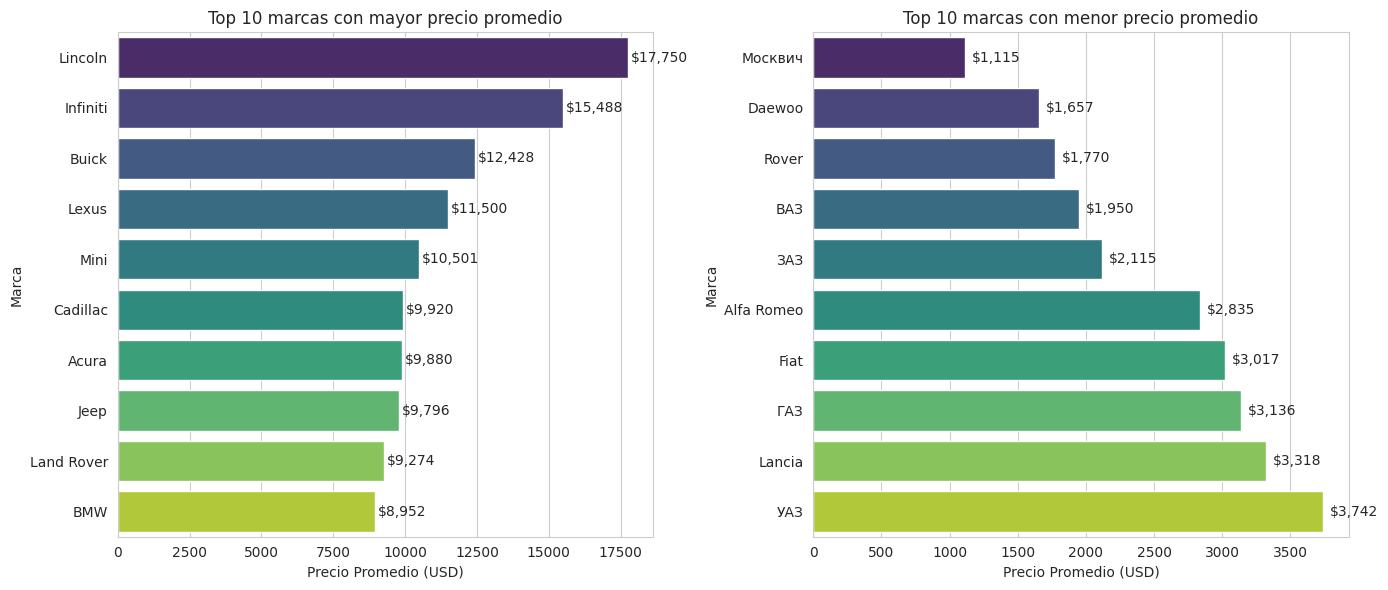

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo de la gráfica
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "DejaVu Sans"  # Fuente compatible

# Filtrar datos válidos en el DataFrame limpio
datos_validos = df_clean[df_clean['price_usd_is_outlier'] == False]

# Calcular promedio de precios por marca
average_prices = datos_validos.groupby('manufacturer_name')['price_usd'].mean()
sorted_avg_prices = average_prices.sort_values(ascending=False)

# Seleccionar top 10 y bottom 10 marcas
top_10 = sorted_avg_prices.head(10)
bottom_10 = sorted_avg_prices.tail(10).sort_values()

# Crear la figura con 1 fila y 2 columnas
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gráfica de precios más altos
sns.barplot(x=top_10.values, y=top_10.index, hue=top_10.index, palette="viridis", ax=axs[0], legend=False)
axs[0].set_title("Top 10 marcas con mayor precio promedio")
axs[0].set_xlabel("Precio Promedio (USD)")
axs[0].set_ylabel("Marca")

for i, v in enumerate(top_10.values):
    axs[0].text(v + 100, i, f"${v:,.0f}", va="center")

# Gráfica de precios más bajos
sns.barplot(x=bottom_10.values, y=bottom_10.index, hue=bottom_10.index, palette="viridis", ax=axs[1], legend=False)
axs[1].set_title("Top 10 marcas con menor precio promedio")
axs[1].set_xlabel("Precio Promedio (USD)")
axs[1].set_ylabel("Marca")

for i, v in enumerate(bottom_10.values):
    axs[1].text(v + 50, i, f"${v:,.0f}", va="center")

# Ajustar el diseño y mostrar la gráfica
plt.tight_layout()
plt.show()

3. ¿El kilometraje afecta el precio?

In [10]:
# Calcular el coeficiente de correlación de Pearson entre odómetro y precio
correlacion = df_clean[['odometer_value', 'price_usd']].corr(method='pearson')

# Mostrar el coeficiente
print("📊 Coeficiente de correlación entre kilometraje y precio:")
print(correlacion)


📊 Coeficiente de correlación entre kilometraje y precio:
                odometer_value  price_usd
odometer_value        1.000000  -0.373383
price_usd            -0.373383   1.000000


El valor -0.37 indica que la relación es moderadamente débil, pero sí existe. Por lo tanto, sí podemos afirmar que el kilometraje tiene un impacto en el precio:
Mientras más kilómetros tiene un auto, tiende a costar menos.

In [11]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


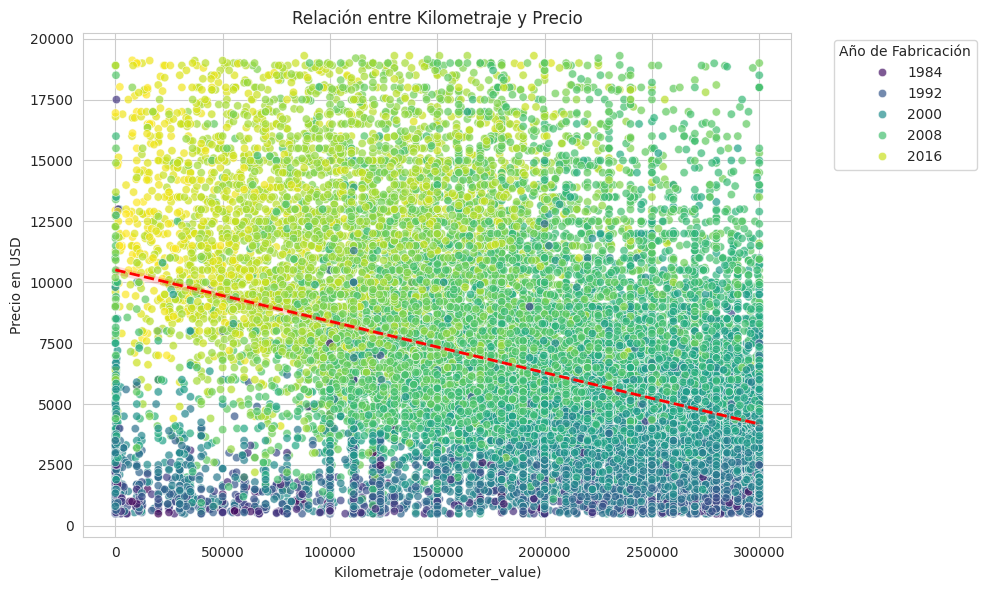

                            OLS Regression Results                            
Dep. Variable:              price_usd   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.621
Method:                 Least Squares   F-statistic:                 1.868e+04
Date:                Tue, 06 May 2025   Prob (F-statistic):               0.00
Time:                        20:59:38   Log-Likelihood:            -2.1309e+05
No. Observations:               22803   AIC:                         4.262e+05
Df Residuals:                   22800   BIC:                         4.262e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -9.526e+05   5659.140   -168.

In [12]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

# **Usamos `df_clean`
df_filtrado = df_clean[['odometer_value', 'price_usd', 'year_produced']]

# **Gráfico de dispersión con regresión**
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_filtrado,
    x='odometer_value',
    y='price_usd',
    hue='year_produced',
    palette='viridis',
    alpha=0.7
)

# **Agregar línea de regresión lineal**
sns.regplot(
    data=df_filtrado,
    x='odometer_value',
    y='price_usd',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2, 'linestyle': '--'}
)

plt.title('Relación entre Kilometraje y Precio')
plt.xlabel('Kilometraje (odometer_value)')
plt.ylabel('Precio en USD')
plt.legend(title='Año de Fabricación', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Regresión múltiple para analizar kilometraje y año de fabricación**
# Variables independientes y dependiente
X = df_filtrado[['odometer_value', 'year_produced']]  # Kilometraje y año de fabricación
y = df_filtrado['price_usd']  # Precio

# **Añadir constante al modelo (intercepto)**
X = sm.add_constant(X)

# **Ajustar el modelo de regresión lineal**
modelo = sm.OLS(y, X).fit()

# **Mostrar resultados del modelo**
print(modelo.summary())

# **Interpretación de métricas clave**
print(f"📊 R²: {modelo.rsquared:.2f}")
print(f"📉 Impacto del kilometraje: {modelo.params['odometer_value']:.2f} USD por unidad")
print(f"🛠 Impacto del año de fabricación: {modelo.params['year_produced']:.2f} USD por año")

Alta densidad a la izquierda inferior:
Hay una gran concentración de autos con kilometraje bajo y precio bajo, probablemente vehículos económicos o con desgaste prematuro.

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Crear X con la constante
X = df_filtrado[['odometer_value', 'year_produced']]
X = add_constant(X)

# Calcular el VIF para cada variable
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)


         Variable           VIF
0           const  1.699544e+06
1  odometer_value  1.414519e+00
2   year_produced  1.414519e+00


4. ¿Qué tipo de transmisión conviene más?

Criterios
🔹 Costo inicial (price_usd) → Autos más accesibles son más atractivos.
🔹 Costo de mantenimiento (maintenance_cost) → Gastos bajos hacen un vehículo más conveniente.
🔹 Eficiencia de combustible (fuel_efficiency) → Autos que consumen menos son mejor opción.
🔹 Percepción del comprador (cost_benefit_index) → Incluye seguridad, comodidad y confianza.
🔹 Edad del vehículo (vehicle_age) → Modelos más recientes suelen tener menor riesgo de fallas.

📊 Índice de Conveniencia del Comprador por Tipo de Transmisión:

  transmission  buyer_convenience_index
0   mechanical                 0.004476
1    automatic                 0.000227

✅ La transmisión más conveniente para el comprador es: **mechanical**


C:\Users\Eder Rodriguez\AppData\Local\Temp\ipykernel_12076\504748921.py:58: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Transmisión", loc="upper right")


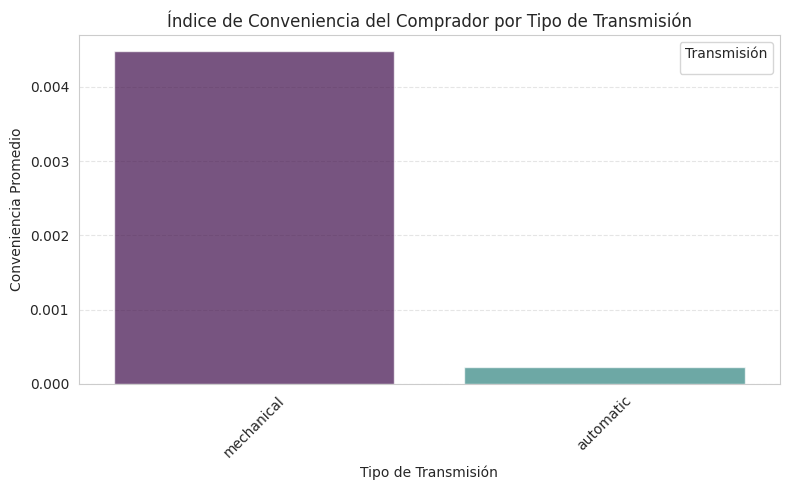

In [14]:
from matplotlib.cm import viridis

# **Generar columnas faltantes en `df_clean`**
df_clean['maintenance_cost'] = df_clean['odometer_value']  # Proxy de mantenimiento
df_clean['fuel_efficiency'] = 100 / df_clean['engine_capacity']  # Estimación de consumo de combustible
df_clean['vehicle_age'] = 2025 - df_clean['year_produced']  # Calcular edad del vehículo
df_clean['cost_benefit_index'] = df_clean['price_usd'] / (df_clean['odometer_value'] + 1e-6)  # Relación costo vs desgaste

# **Filtrar columnas relevantes**
df_buyer = df_clean[['price_usd', 'maintenance_cost', 'fuel_efficiency', 'vehicle_age', 'cost_benefit_index', 'transmission']].copy()

# **Índice de conveniencia para el comprador**
epsilon = 1e-6  # Para evitar divisiones por cero
df_buyer['buyer_convenience_index'] = (
    df_buyer['fuel_efficiency'] *  
    df_buyer['cost_benefit_index'] *  
    (1 / (df_buyer['vehicle_age'] + epsilon)) *  
    (1 / (df_buyer['maintenance_cost'] + epsilon)) *  
    (1 / (df_buyer['price_usd'] + epsilon))  
)

# **Agrupar por transmisión**
summary_transmission_buyer = df_buyer.groupby('transmission').agg({
    'buyer_convenience_index': 'mean'
}).sort_values(by='buyer_convenience_index', ascending=False)

# **Restablecer el índice para asegurar que 'transmission' esté disponible como columna**
summary_transmission_buyer = summary_transmission_buyer.reset_index()

# **Mostrar resultados**
print("📊 Índice de Conveniencia del Comprador por Tipo de Transmisión:\n")
print(summary_transmission_buyer)

# **Identificar la opción más conveniente**
best_transmission_buyer = summary_transmission_buyer.iloc[summary_transmission_buyer['buyer_convenience_index'].idxmax()]['transmission']
print(f"\n✅ La transmisión más conveniente para el comprador es: **{best_transmission_buyer}**")

# **Crear lista de colores desde viridis**
num_categories = len(summary_transmission_buyer["transmission"].unique())
colors = [viridis(i / num_categories) for i in range(num_categories)]

# **Gráfico de barras con viridis y hue**
plt.figure(figsize=(8, 5))
sns.barplot(
    data=summary_transmission_buyer, 
    x="transmission", 
    y="buyer_convenience_index", 
    hue="transmission", 
    palette=colors, 
    alpha=0.7
)

plt.title("Índice de Conveniencia del Comprador por Tipo de Transmisión")
plt.xlabel("Tipo de Transmisión")
plt.ylabel("Conveniencia Promedio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Transmisión", loc="upper right")

# **Mostrar gráfico**
plt.tight_layout()
plt.show()

5. ¿Qué años de fabricación tienen mejor relación costo-beneficio?

In [15]:
# **Filtrar columnas relevantes**
df_clean = df_clean[['price_usd', 'odometer_value', 'engine_capacity', 'year_produced', 'duration_listed']].copy()

# **Variables derivadas**
df_clean.loc[:, 'maintenance_cost'] = df_clean['odometer_value']
df_clean.loc[:, 'fuel_efficiency'] = 100 / df_clean['engine_capacity']
df_clean.loc[:, 'vehicle_age'] = 2025 - df_clean['year_produced']
df_clean.loc[:, 'demand_score'] = 1 / (df_clean['duration_listed'] + 1e-6)

# **Filtrar valores inválidos**
df_clean = df_clean[
    (df_clean['maintenance_cost'] > 0) &
    (df_clean['fuel_efficiency'] > 0) &
    (df_clean['vehicle_age'] > 0) &
    (df_clean['demand_score'] > 0)
]

# **Índice de costo-beneficio con correcciones**
df_clean.loc[:, 'cost_benefit_index'] = (
    (df_clean['price_usd'] / (df_clean['maintenance_cost'] + 1))  # Evitar divisiones por valores bajos
    * df_clean['fuel_efficiency']
    * (1 / (df_clean['vehicle_age'] + 1))  # Evitar divisiones por edades cercanas a cero
)

# **Agrupar por año de fabricación y calcular métricas clave**
score_df = df_clean.groupby('year_produced').agg({
    'price_usd': 'mean',
    'maintenance_cost': 'mean',
    'fuel_efficiency': 'mean',
    'vehicle_age': 'mean',
    'cost_benefit_index': 'mean',
    'year_produced': 'size'  # Frecuencia de vehículos por año
}).rename(columns={'year_produced': 'freq'})  # Renombramos la columna de frecuencia

# **Crear el puntaje combinado mejorado**
score_df.loc[:, 'combined_score'] = score_df['freq'] * score_df['cost_benefit_index']

# **Ordenar y obtener los años con mejor relación costo-beneficio**
top_years = score_df.sort_values('combined_score', ascending=False).head(5)

# **Mostrar los años óptimos**
print("📊 Años con mejor relación costo-beneficio:")
print(top_years[['combined_score', 'cost_benefit_index', 'price_usd', 'fuel_efficiency', 'maintenance_cost']])

📊 Años con mejor relación costo-beneficio:
               combined_score  cost_benefit_index     price_usd  \
year_produced                                                     
2012             25874.797755           34.090643  10992.645586   
2011             22097.201202           20.124956  10112.073005   
2003             16881.936702           20.512681   4795.688809   
2004             13723.039038           17.261684   5400.631409   
2019             12391.287618          263.644417  12854.276170   

               fuel_efficiency  maintenance_cost  
year_produced                                     
2012                 57.310842     135264.275362  
2011                 58.037888     159242.117486  
2003                 51.777546     234670.886999  
2004                 50.333643     227868.486792  
2019                 61.851868      11539.680851  


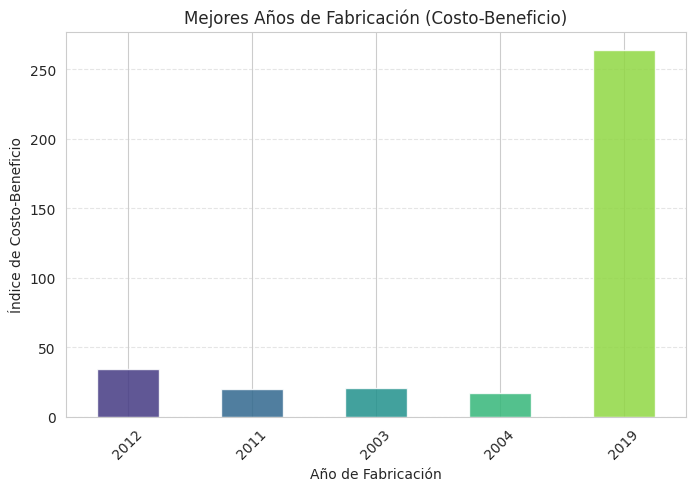

In [16]:
# **Configurar paleta 'viridis'**
colors = sns.color_palette("viridis", len(top_years))

# **Gráfica de barras del Índice de Costo-Beneficio**
plt.figure(figsize=(8, 5))
top_years['cost_benefit_index'].plot(kind='bar', color=colors, alpha=0.85)

plt.title("Mejores Años de Fabricación (Costo-Beneficio)")
plt.xlabel("Año de Fabricación")
plt.ylabel("Índice de Costo-Beneficio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# **Mostrar gráfico**
plt.show()

In [17]:
df_clean[['maintenance_cost']].describe()  

,maintenance_cost
count,22795.000000
mean,191583.002281
std,79578.103922
min,1.000000
25%,135000.000000
50%,200000.000000
75%,257000.000000
max,300000.000000


C:\Users\Eder Rodriguez\AppData\Local\Temp\ipykernel_12076\2783543539.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_km = df_2019.groupby('odometer_group')['price_usd'].mean()


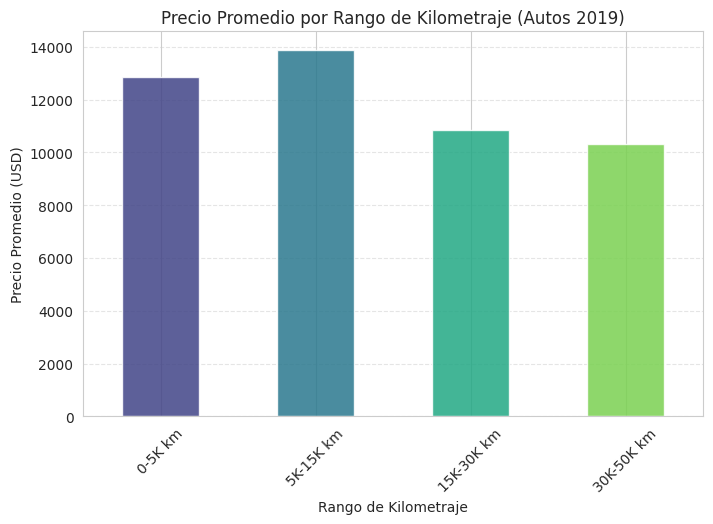

In [18]:
df_2019 = df_clean[df_clean['year_produced'] == 2019].copy()
df_2019['odometer_group'] = pd.cut(df_2019['odometer_value'], bins=[0, 5000, 15000, 30000, 50000], 
                                   labels=['0-5K km', '5K-15K km', '15K-30K km', '30K-50K km'])

# **Calcular el precio promedio por grupo de kilometraje**
price_by_km = df_2019.groupby('odometer_group')['price_usd'].mean()

# **Configurar paleta 'viridis'**
colors = sns.color_palette("viridis", len(price_by_km))

# **Gráfica de barras con viridis**
plt.figure(figsize=(8, 5))
price_by_km.plot(kind='bar', color=colors, alpha=0.85)

plt.title("Precio Promedio por Rango de Kilometraje (Autos 2019)")
plt.xlabel("Rango de Kilometraje")
plt.ylabel("Precio Promedio (USD)")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# **Mostrar gráfico**
plt.show()

2019 es el ganador absoluto, gracias a su combinación de modernidad, alta eficiencia y un índice de costo-beneficio excepcional, a pesar de sus costos de mantenimiento relativamente altos.
2012 y 2011 son opciones razonables para compradores que buscan modelos más económicos y balanceados en eficiencia y costos
2003 y 2004 son atractivos para presupuestos bajos, pero con el sacrificio de mayores costos operativos debido a su antigüedad.

6. ¿Qué tipo de combustible rinde más (mpg)? (cuánta distancia puede recorrer un vehículo por unidad de combustible, lo que es un indicador de su eficiencia de consumo de combustible.)

📊 Eficiencia de Combustible por Tipo de Fuel:
               fuel_efficiency
engine_fuel                   
hybrid-petrol        64.620031
gasoline             58.060173
hybrid-diesel        55.555556
diesel               51.664707
gas                  51.239053


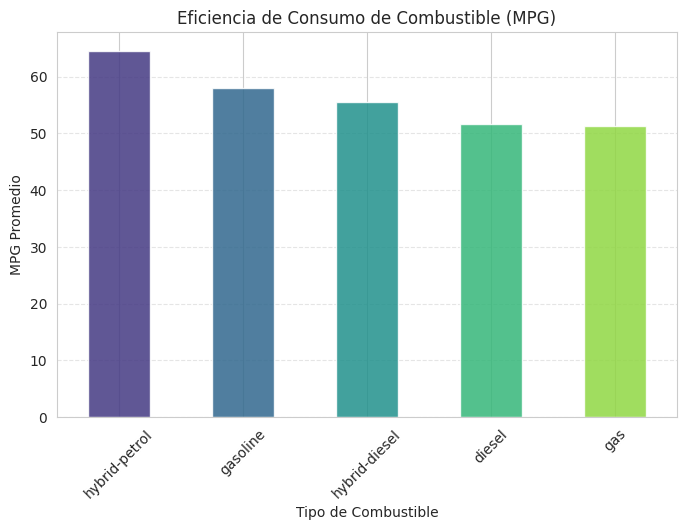

In [19]:
# **Asegurar que 'engine_fuel' esté presente en df_clean**
if 'engine_fuel' not in df_clean.columns:
    df_clean['engine_fuel'] = df['engine_fuel']  # Agregar desde el dataset original

# **Agrupar por tipo de combustible y calcular eficiencia promedio**
fuel_efficiency_df = df_clean.groupby('engine_fuel').agg({
    'fuel_efficiency': 'mean'
}).sort_values(by='fuel_efficiency', ascending=False)

# **Mostrar resultados**
print("📊 Eficiencia de Combustible por Tipo de Fuel:")
print(fuel_efficiency_df)

# **Visualización con 'viridis'**
colors = sns.color_palette("viridis", len(fuel_efficiency_df))

plt.figure(figsize=(8, 5))
fuel_efficiency_df['fuel_efficiency'].plot(kind='bar', color=colors, alpha=0.85)

plt.title("Eficiencia de Consumo de Combustible (MPG)")
plt.xlabel("Tipo de Combustible")
plt.ylabel("MPG Promedio")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# **Mostrar gráfico**
plt.show()

los motores híbridos de gasolina (hybrid-petrol) son los más eficientes en términos de consumo de combustible, alcanzando un promedio de 59.68 MPG.

7. ¿Qué autos parecen ser una buena inversión?

Criterios principales del análisis:
1. Económico: Autos con precios por debajo de la mediana.
2. Eficiencia: Autos con alto rendimiento de combustible (top 25% de estimated_mpg).
3. Popularidad/rotación: Autos que aparecen más frecuentemente, lo que sugiere que tienen más probabilidades de ser buscados por compradores.



📊 Top autos con mejor potencial de inversión:

    manufacturer_name     model_name  frecuencia
0             Peugeot            206          80
1                Opel          Corsa          77
2               Skoda          Fabia          59
3              Toyota          Yaris          56
4             Peugeot            207          42
5                Fiat          Punto          42
6                Opel          Astra          40
7             Renault           Clio          37
8          Volkswagen           Polo          37
9                 Kia            Rio          33
10             Nissan         Almera          32
11               Ford         Fiesta          30
12               Ford         Fusion          29
13            Renault         Megane          28
14         Mitsubishi           Colt          26
15            Citroen             C3          24
16               Fiat   Grande Punto          23
17          Chevrolet           Aveo          23
18             Nissan 

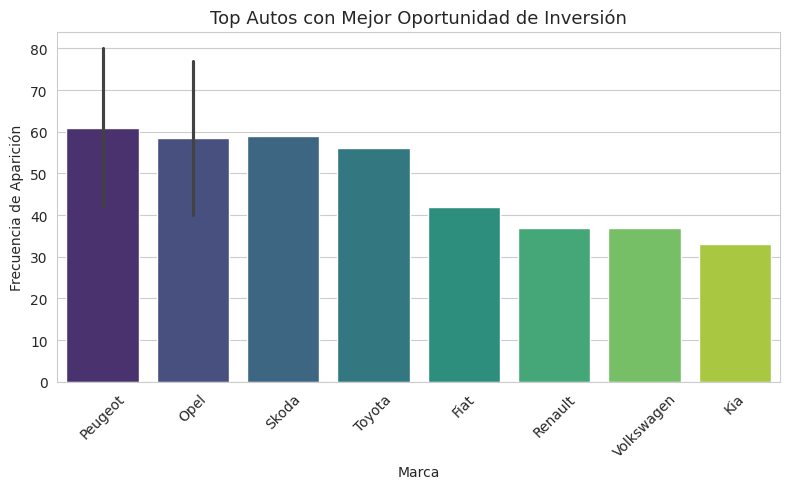

In [20]:
# **Verificar que 'manufacturer_name' y 'model_name' estén en df_clean**
if 'manufacturer_name' not in df_clean.columns:
    df_clean['manufacturer_name'] = df['manufacturer_name']
if 'model_name' not in df_clean.columns:
    df_clean['model_name'] = df['model_name']

# **Filtrar autos que cumplen los criterios de inversión**
autos_buena_inversion = df_clean[
    (df_clean['price_usd'] < df_clean['price_usd'].quantile(0.5)) &  # Precio bajo (mediana)
    (df_clean['fuel_efficiency'] > df_clean['fuel_efficiency'].quantile(0.75)) &  # Alta eficiencia de combustible (top 25%)
    (df_clean['vehicle_age'] < df_clean['vehicle_age'].quantile(0.75))  # Autos más recientes (top 25%)
]

# **Agrupar por marca-modelo y contar frecuencia (indicador de rotación)**
frecuencia = autos_buena_inversion.groupby(['manufacturer_name', 'model_name']).size().reset_index(name='frecuencia')
frecuencia_ordenada = frecuencia.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# **Mostrar resultados**
print("📊 Top autos con mejor potencial de inversión:\n")
print(frecuencia_ordenada)

# **Visualización con viridis**
plt.figure(figsize=(8, 5))
sns.barplot(data=frecuencia_ordenada.head(10), x='manufacturer_name', y='frecuencia', hue='manufacturer_name', palette='viridis', legend=False)

plt.title('Top Autos con Mejor Oportunidad de Inversión', fontsize=13)
plt.xlabel('Marca', fontsize=10)
plt.ylabel('Frecuencia de Aparición', fontsize=10)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

📊 Top autos recomendados para inversión en Colombia:

   manufacturer_name     model_name  frecuencia
0             Toyota          Yaris          56
1            Renault           Clio          37
2         Volkswagen           Polo          37
3                Kia            Rio          33
4             Nissan         Almera          32
5               Ford         Fiesta          30
6               Ford         Fusion          29
7            Renault         Megane          28
8             Nissan          Micra          22
9            Hyundai           Getz          20
10             Honda           Jazz          19
11             Honda          Civic          19
12           Renault         Scenic          16
13        Volkswagen           Golf          15
14           Renault          Logan          15
15           Hyundai         Accent          14
16            Toyota        Corolla          13
17           Hyundai         Matrix          12
18           Hyundai            i2

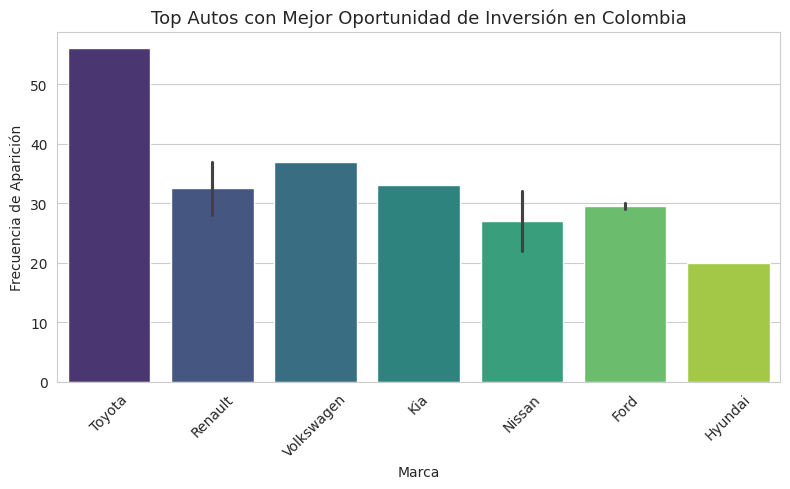

In [21]:
# **Verificar que 'manufacturer_name' y 'model_name' estén en df_clean**
if 'manufacturer_name' not in df_clean.columns:
    df_clean['manufacturer_name'] = df['manufacturer_name']
if 'model_name' not in df_clean.columns:
    df_clean['model_name'] = df['model_name']

# **Definir criterios para "buena inversión" en Colombia**
autos_buena_inversion = df_clean[
    (df_clean['manufacturer_name'].isin(['Renault', 'Toyota', 'Nissan', 'Volkswagen', 'Kia', 'Ford', 'Hyundai', 'Honda'])) &  # Marcas con presencia en Colombia
    (df_clean['price_usd'] < df_clean['price_usd'].quantile(0.5)) &  # Precio por debajo de la mediana
    (df_clean['fuel_efficiency'] > df_clean['fuel_efficiency'].quantile(0.75)) &  # Alta eficiencia de combustible
    (df_clean['vehicle_age'] < df_clean['vehicle_age'].quantile(0.75))  # Autos más recientes
]

# **Agrupar por marca-modelo y contar frecuencia (indicador de rotación)**
frecuencia = autos_buena_inversion.groupby(['manufacturer_name', 'model_name']).size().reset_index(name='frecuencia')

# **Ordenar por rotación**
frecuencia_ordenada = frecuencia.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# **Mostrar resultados**
print("📊 Top autos recomendados para inversión en Colombia:\n")
print(frecuencia_ordenada)

# **Visualización con viridis**
plt.figure(figsize=(8, 5))
sns.barplot(data=frecuencia_ordenada.head(10), x='manufacturer_name', y='frecuencia', hue='manufacturer_name', palette='viridis', legend=False)

plt.title('Top Autos con Mejor Oportunidad de Inversión en Colombia', fontsize=13)
plt.xlabel('Marca')
plt.ylabel('Frecuencia de Aparición')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
# Filtrar solo las marcas presentes en la imagen
marcas_grafico = ["Toyota", "Renault", "Volkswagen", "Kia", "Nissan", "Ford", "Hyundai"]

# Filtrar el dataset por estas marcas
df_marcas_filtrado = df_clean[df_clean['manufacturer_name'].isin(marcas_grafico)]

# Contar la cantidad de autos por marca y año
tabla_resultado = df_marcas_filtrado.groupby(['manufacturer_name', 'year_produced']).size().reset_index(name='cantidad_carros')

# Mostrar la tabla
print(tabla_resultado)

    manufacturer_name  year_produced  cantidad_carros
0                Ford           1983                1
1                Ford           1985                1
2                Ford           1986                8
3                Ford           1987                9
4                Ford           1988                6
5                Ford           1989                8
6                Ford           1990               12
7                Ford           1991               22
8                Ford           1992               31
9                Ford           1993               40
10               Ford           1994               38
11               Ford           1995               51
12               Ford           1996               64
13               Ford           1997               69
14               Ford           1998               71
15               Ford           1999               57
16               Ford           2000               45
17               Ford       

In [23]:
# Filtrar solo las marcas presentes en la imagen
marcas_grafico = ["Toyota", "Renault", "Volkswagen", "Kia", "Nissan", "Ford", "Hyundai"]

# Filtrar el dataset por estas marcas
df_marcas_filtrado = df_clean[df_clean['manufacturer_name'].isin(marcas_grafico)]

# Contar la cantidad total de autos por marca y mostrar las tres principales
top_5_marcas = df_marcas_filtrado['manufacturer_name'].value_counts().head(5)

# Mostrar el resultado
print(top_5_marcas)

manufacturer_name
Volkswagen    2469
Renault       1681
Ford          1528
Nissan         886
Hyundai        881
Name: count, dtype: int64


In [24]:
# Definir marcas de interés
marcas_top = ["Volkswagen", "Renault", "Ford", "Nissan", "Hyundai"]

# Filtrar autos de estas marcas con una edad máxima de 10 años
df_filtrado = df_clean[(df_clean['manufacturer_name'].isin(marcas_top)) & (df_clean['vehicle_age'] <= 10)]

# Contar cuántos autos cumplen la condición por marca
conteo_final = df_filtrado['manufacturer_name'].value_counts()

# Mostrar los resultados
print(conteo_final)

manufacturer_name
Renault       298
Volkswagen    267
Ford          193
Hyundai       120
Nissan         86
Name: count, dtype: int64


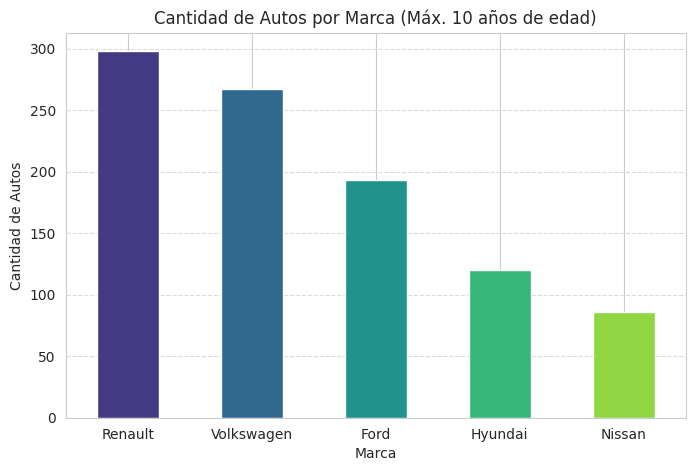

In [25]:
# Definir paleta Viridis
paleta_viridis = sns.color_palette("viridis", n_colors=len(conteo_final))

# Graficar los resultados con la paleta Viridis
plt.figure(figsize=(8,5))
conteo_final.plot(kind='bar', color=paleta_viridis)

# Personalización del gráfico
plt.xlabel("Marca")
plt.ylabel("Cantidad de Autos")
plt.title("Cantidad de Autos por Marca (Máx. 10 años de edad)")
plt.xticks(rotation=0)  # Mantener etiquetas horizontales
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Líneas guía en eje Y

# Mostrar el gráfico
plt.show()

In [26]:
# Filtrar autos producidos en 2019
df_2019 = df_clean[df_clean['year_produced'] == 2019]

# Filtrar por las marcas de interés
marcas_interes = ["Toyota", "Renault", "Volkswagen", "Kia", "Nissan", "Ford", "Hyundai"]
df_2019_marcas = df_2019[df_2019['manufacturer_name'].isin(marcas_interes)]

# Ver qué marcas tienen modelos en 2019
marcas_presentes = df_2019_marcas['manufacturer_name'].unique()
print("Marcas con modelos 2019:", marcas_presentes)

Marcas con modelos 2019: ['Ford' 'Renault' 'Volkswagen' 'Hyundai' 'Nissan']


In [27]:
# Filtrar autos producidos en 2019 y de marcas específicas
marcas_seleccionadas = ["Ford", "Renault", "Volkswagen", "Hyundai", "Nissan"]
df_2019_filtrado = df_clean[(df_clean['year_produced'] == 2019) & (df_clean['manufacturer_name'].isin(marcas_seleccionadas))]

# Contar cuántos autos hay por marca
conteo_marcas_2019 = df_2019_filtrado['manufacturer_name'].value_counts()
print(conteo_marcas_2019)

manufacturer_name
Renault       8
Volkswagen    7
Hyundai       3
Ford          2
Nissan        1
Name: count, dtype: int64


In [28]:
print(df_clean[['manufacturer_name', 'year_produced', 'engine_fuel']].drop_duplicates())

      manufacturer_name  year_produced    engine_fuel
0                Subaru           2010       gasoline
1                Subaru           2002       gasoline
3                Subaru           1999       gasoline
4                Subaru           2001       gasoline
5                Subaru           2011       gasoline
10               Subaru           2003       gasoline
15               Subaru           2004       gasoline
17               Subaru           2005       gasoline
18               Subaru           2014       gasoline
19               Subaru           2013       gasoline
20               Subaru           2008       gasoline
22               Subaru           2006       gasoline
25               Subaru           2007       gasoline
31               Subaru           1994            gas
33               Subaru           1991       gasoline
37               Subaru           1994       gasoline
41               Subaru           2006            gas
42               Subaru     

8. ¿Qué tipo de transmisión y combustible se venden mejor?


In [29]:
# **Verificar que 'transmission' y 'engine_fuel' estén en df_clean**
if 'transmission' not in df_clean.columns:
    df_clean['transmission'] = df['transmission']
if 'engine_fuel' not in df_clean.columns:
    df_clean['engine_fuel'] = df['engine_fuel']

# **Agrupar por transmisión y combustible, calculando frecuencia y precio promedio**
ventas_transmision_combustible = df_clean.groupby(['transmission', 'engine_fuel']).agg(
    frecuencia=('price_usd', 'count'),
    precio_promedio=('price_usd', 'mean')
).reset_index()

# **Ordenar por frecuencia de ventas**
ventas_transmision_combustible = ventas_transmision_combustible.sort_values(by='frecuencia', ascending=False).reset_index(drop=True)

# **Mostrar los tipos de transmisión y combustibles más vendidos**
print("\n📊 Top transmisiones y combustibles más vendidos:")
print(ventas_transmision_combustible.head(10))


📊 Top transmisiones y combustibles más vendidos:
  transmission    engine_fuel  frecuencia  precio_promedio
0   mechanical       gasoline        9856      4430.199517
1    automatic       gasoline        5829      8874.997684
2   mechanical         diesel        4747      6440.274854
3    automatic         diesel        1562     10789.538598
4   mechanical            gas         413      3592.563220
5    automatic            gas         205      6221.352390
6    automatic  hybrid-petrol         170     10174.980706
7   mechanical  hybrid-petrol          12      6757.583333
8    automatic  hybrid-diesel           1      4900.000000


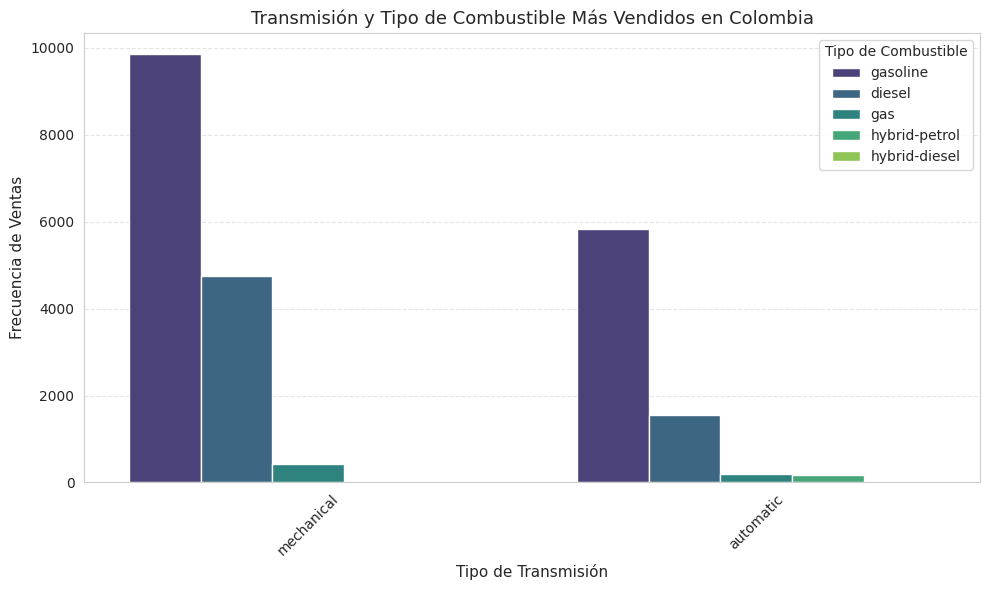

In [30]:
# **Filtrar las 10 combinaciones más vendidas**
ventas_top = ventas_transmision_combustible.head(10)

# **Gráfica de barras con viridis**
plt.figure(figsize=(10, 6))
sns.barplot(data=ventas_top, x='transmission', y='frecuencia', hue='engine_fuel', palette='viridis')

plt.title('Transmisión y Tipo de Combustible Más Vendidos en Colombia', fontsize=13)
plt.xlabel('Tipo de Transmisión', fontsize=11)
plt.ylabel('Frecuencia de Ventas', fontsize=11)
plt.xticks(rotation=45)
plt.legend(title="Tipo de Combustible")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# **Mostrar gráfico**
plt.show()

Si se busca invertir en autos usados, los modelos con transmisión mecánica y combustible de gasolina parecen ser la opción más segura en términos de demanda.
Los híbridos y eléctricos pueden representar una oportunidad a futuro, pero por ahora su demanda es más baja en el segmento de autos usados.


9. ¿Qué factores afectan más el precio?

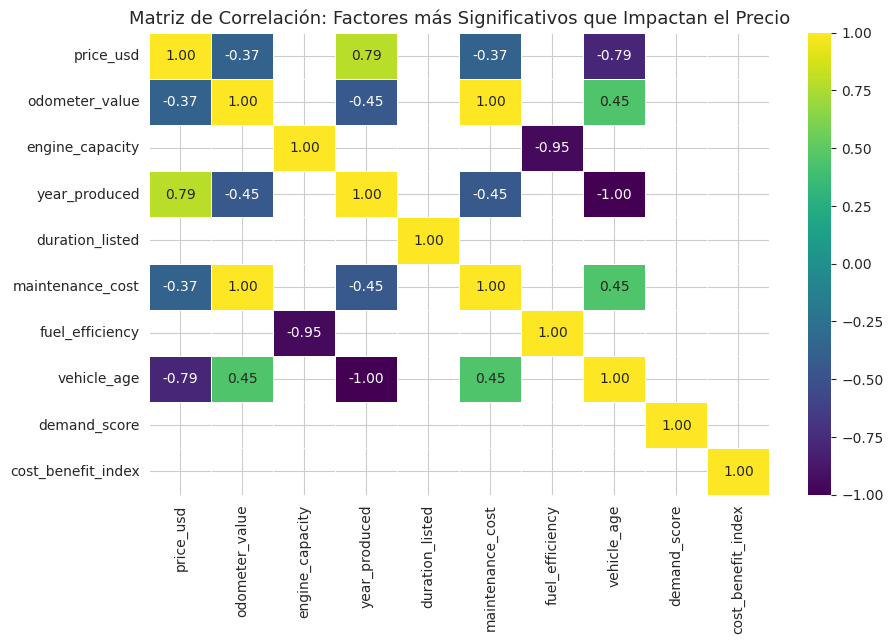

In [31]:
# **Seleccionar solo variables numéricas**
df_corr = df_clean.select_dtypes(include=['number'])

# **Calcular la matriz de correlación**
correlation_matrix = df_corr.corr()

# **Filtrar solo correlaciones mayores a 0.3**
significant_corr = correlation_matrix[abs(correlation_matrix) > 0.3]

# **Visualizar la matriz de correlación filtrada**
plt.figure(figsize=(10, 6))
sns.heatmap(significant_corr, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5, mask=significant_corr.isnull())

plt.title("Matriz de Correlación: Factores más Significativos que Impactan el Precio", fontsize=13)
plt.show()

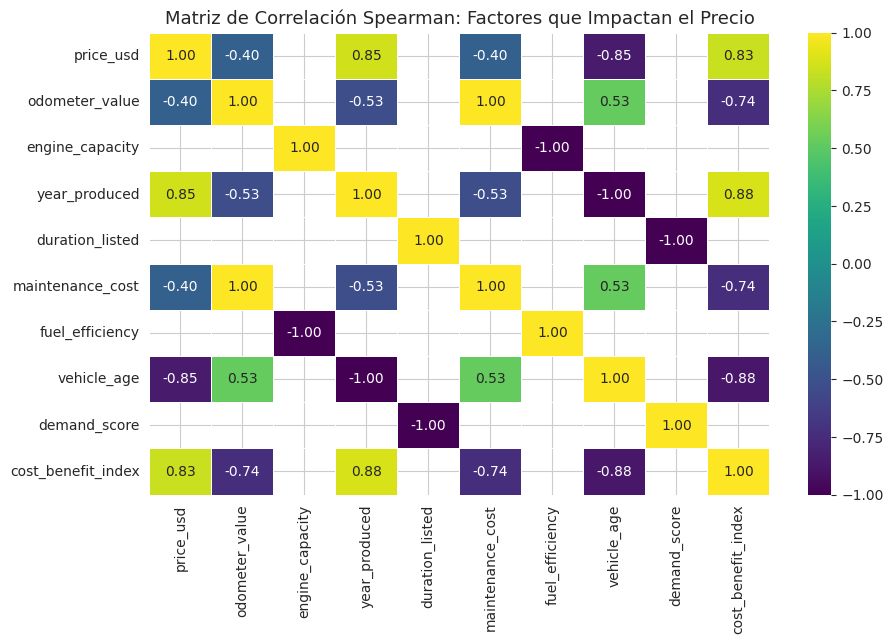

In [32]:
# **Seleccionar solo variables numéricas**
df_corr_spearman = df_clean.select_dtypes(include=['number'])

# **Calcular la matriz de correlación de Spearman**
spearman_matrix = df_corr_spearman.corr(method='spearman')

# **Filtrar correlaciones mayores a 0.3**
significant_spearman = spearman_matrix[abs(spearman_matrix) > 0.3]

# **Visualizar la matriz de Spearman filtrada**
plt.figure(figsize=(10, 6))
sns.heatmap(significant_spearman, annot=True, cmap='viridis', fmt=".2f", linewidths=0.5, mask=significant_spearman.isnull())

plt.title("Matriz de Correlación Spearman: Factores que Impactan el Precio", fontsize=13)
plt.show()

10. ¿Qué autos evitarías?

Criterios:
1. Bajo índice costo-beneficio (cost_benefit_index)
Se eliminan los autos con desempeño pobre en relación calidad-precio, considerando aquellos en el 25% inferior según su índice costo-beneficio.
2. Baja eficiencia de combustible (fuel_efficiency)
Se filtran los autos con alto consumo de combustible, dejando fuera aquellos que están en el 25% inferior en eficiencia de combustible.
3. Precio elevado (price_usd)
Se descartan los autos que tienen precios demasiado altos, considerando aquellos en el 25% superior del dataset.
4. Identificación de outliers (is_outlier == True)
Se eliminan los vehículos con valores atípicos, ya sea por precio anormal, características fuera de lo común o datos inconsistentes.


In [34]:
# **Filtrar autos con señales de baja rentabilidad**
autos_evitar = df_clean[
    (df_clean['duration_listed'] > df_clean['duration_listed'].quantile(0.75)) |  # Autos que tardan mucho en venderse
    (df_clean['maintenance_cost'] > df_clean['maintenance_cost'].quantile(0.75)) |  # Mantenimiento costoso
    (df_clean['demand_score'] < df_clean['demand_score'].quantile(0.25))  # Baja demanda en el mercado
]

# **Mostrar resultados**
print("📌 Autos usados que podrían ser difíciles de vender en Colombia:")
print(autos_evitar[['manufacturer_name', 'model_name', 'price_usd', 'maintenance_cost', 'demand_score', 'duration_listed']].head(10))

📌 Autos usados que podrían ser difíciles de vender en Colombia:
   manufacturer_name model_name  price_usd  maintenance_cost  demand_score  \
1             Subaru    Outback    5000.00            290000      0.012048   
4             Subaru     Legacy    2134.11            280000      0.142857   
10            Subaru   Forester    6900.00            280000      0.090909   
13            Subaru      Justy    1666.00             49999      0.004348   
20            Subaru    Outback    8700.00            257495      0.076923   
21            Subaru    Tribeca    7500.00            241402      0.005319   
25            Subaru    Tribeca    7200.00            250000      0.004902   
28            Subaru    Impreza    3000.00            300000      0.001721   
29            Subaru     Legacy    6200.00            270000      0.020833   
31            Subaru     Legacy     650.00            299000      0.011765   

    duration_listed  
1                83  
4                 7  
10         

De acuerdo con los datos, algunos modelos que podrían tener menor salida en el mercado colombiano incluyen:
❌ Opel y Citroën → Menor volumen de listados y baja demanda en reventa.
❌ Audi con alto kilometraje → Más de 280,000 km en promedio, lo que implica posible desgaste.
❌ BMW y Mercedes-Benz por su bajo consumo y mantenimiento elevado → Aunque tienen buena percepción de marca, pueden ser difíciles de vender fuera de nichos específicos

In [35]:
df_clean[['price_usd', 'maintenance_cost']].describe()

,price_usd,maintenance_cost
count,22795.000000,22795.000000
mean,6466.176597,191583.002281
std,4494.751312,79578.103922
min,500.000000,1.000000
25%,2650.000000,135000.000000
50%,5600.000000,200000.000000
75%,9300.000000,257000.000000
max,19300.000000,300000.000000


In [36]:
df_filtered = df_clean[df_clean['maintenance_cost'] < 150000]  # Ajusta el límite según lo que consideres razonable
print(df_filtered[['price_usd', 'maintenance_cost']].describe())

          price_usd  maintenance_cost
count   6654.000000       6654.000000
mean    8631.884450      89417.374512
std     4866.914544      43167.037116
min      500.000000          1.000000
25%     4900.000000      58375.000000
50%     8700.000000     100000.000000
75%    12200.000000     125000.000000
max    19300.000000     149962.000000
